# Energy-aware Slice Placement – Data Analysis

This notebook analyzes the results obtained from the execution of the proposed
energy-aware MILP and heuristic algorithms for 5G slice placement.

The analysis focuses on:
- acceptance rate 
- total energy consumption,
- node activation and CPU utilization,
- routing characteristics,
- scalability and runtime behavior.

All results are generated from CSV files produced by the simulation pipeline.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")


In [15]:
RESULTS_DIR = "./results/2026-01-21_12-20-57/"  # ajuste aqui

df_metrics = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
df_routes = pd.read_csv(f"{RESULTS_DIR}/routes_all_methods.csv")
df_node_cpu = pd.read_csv(f"{RESULTS_DIR}/node_cpu_load_all_methods.csv")
df_node_vnfs = pd.read_csv(f"{RESULTS_DIR}/node_vnfs_all_methods.csv")


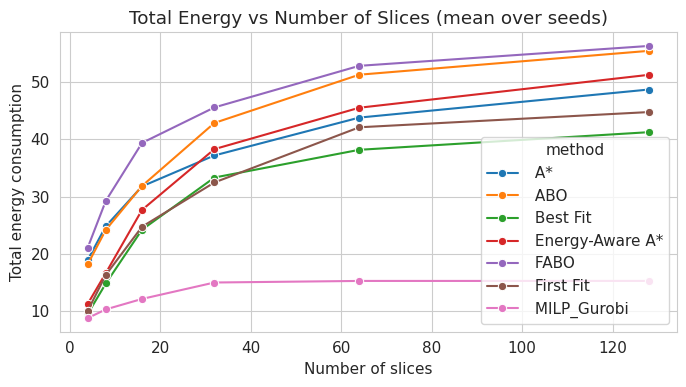

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize column names
df = df_metrics.copy()
df.columns = [c.strip().lower() for c in df.columns]

# Map common alternatives to "method" if needed
if "method" not in df.columns:
    for alt in ["methods", "algorithm", "algo", "name", "model", "solver", "approach"]:
        if alt in df.columns:
            df = df.rename(columns={alt: "method"})
            break

# If method is still missing, it might be the index
if "method" not in df.columns and df.index.name in ("method", "methods", "algorithm"):
    df = df.reset_index()

# Final guardrail
required = {"method", "num_slices", "total_energy"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing columns in df_metrics: {missing}. Available: {list(df.columns)}")

energy_avg = (
    df.groupby(["method", "num_slices"], as_index=False)["total_energy"]
      .mean()
)

sns.lineplot(
    data=energy_avg,
    x="num_slices",
    y="total_energy",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Total energy consumption")
plt.title("Total Energy vs Number of Slices (mean over seeds)")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# --- Normalize column names (handles Method vs method, spaces, etc.) ---
df.columns = [c.strip().lower() for c in df.columns]

# --- Map common alternative names to expected ones (if any) ---
rename_map = {}
if "method" not in df.columns:
    for alt in ["methods", "algorithm", "algo", "approach", "solver"]:
        if alt in df.columns:
            rename_map[alt] = "method"
            break

if "num_slices" not in df.columns:
    for alt in ["slices", "n_slices", "num_slice", "requested_slices", "requested"]:
        if alt in df.columns:
            rename_map[alt] = "num_slices"
            break

if "num_vnfs_per_slice" not in df.columns:
    for alt in ["vnfs_per_slice", "num_vnfs", "vnf_per_slice", "k", "chain_len"]:
        if alt in df.columns:
            rename_map[alt] = "num_vnfs_per_slice"
            break

if "accepted" not in df.columns:
    for alt in ["accepted_slices", "n_accepted", "accepteds", "accepted_count"]:
        if alt in df.columns:
            rename_map[alt] = "accepted"
            break

df = df.rename(columns=rename_map)

# --- Basic checks ---
required_cols = {"method", "num_slices", "num_vnfs_per_slice", "seed", "accepted"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in scalability_results.csv: {missing}. Available: {list(df.columns)}")

# --- Ensure numeric types ---
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce")

df = df.dropna(subset=["method", "num_slices", "num_vnfs_per_slice", "seed", "accepted"])

# --- Remove Best/First Fit (as requested) ---
df = df[~df["method"].isin(["Best Fit", "First Fit"])].copy()

# --- Acceptance rate (%) ---
df["acceptance_rate"] = 100.0 * df["accepted"] / df["num_slices"]

# --- Stable method order (only keep those present) ---
method_order = ["MILP_Gurobi", "A*", "ABO", "FABO", "Energy-Aware A*"]
present_methods = [m for m in method_order if m in df["method"].unique()]
if not present_methods:
    present_methods = sorted(df["method"].unique())

# Optional: make method categorical for consistent plotting order
df["method"] = pd.Categorical(df["method"], categories=present_methods, ordered=True)

df.head()


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,acceptance_rate
0,2026-01-21 12:20:57,4,2,8,1,A*,4,7.432500,60.0,4.0,0.035530,100.0
1,2026-01-21 12:20:57,4,2,8,1,ABO,4,3.372500,60.0,8.0,3.557018,100.0
2,2026-01-21 12:20:57,4,2,8,1,FABO,4,9.449375,60.0,8.0,3.527569,100.0
3,2026-01-21 12:20:57,4,2,8,1,Best Fit,4,3.432500,60.0,4.0,0.014261,100.0
4,2026-01-21 12:20:57,4,2,8,1,First Fit,4,3.372500,60.0,12.0,0.002143,100.0


/tmp/ipykernel_3373661/1199335790.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["num_vnfs_per_slice", "num_slices", "method"])["acceptance_rate"]


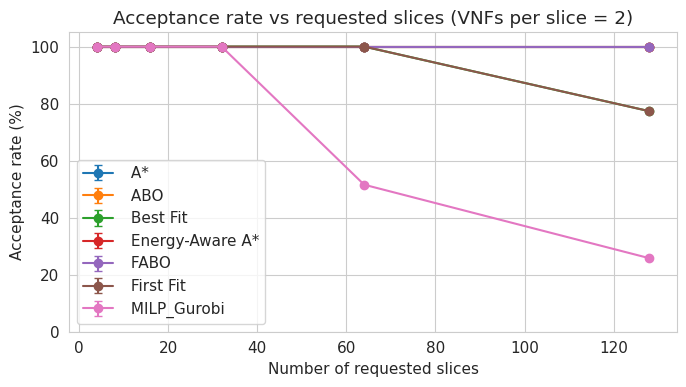

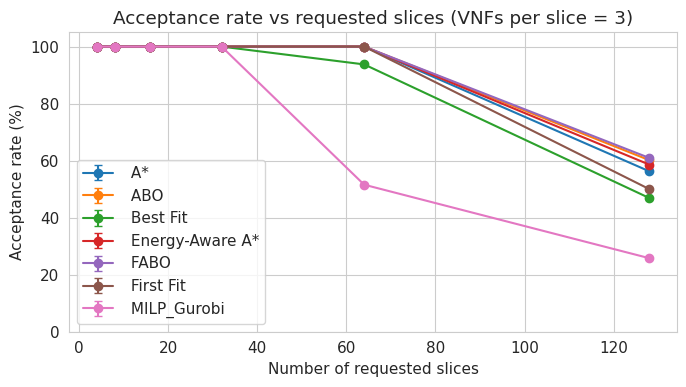

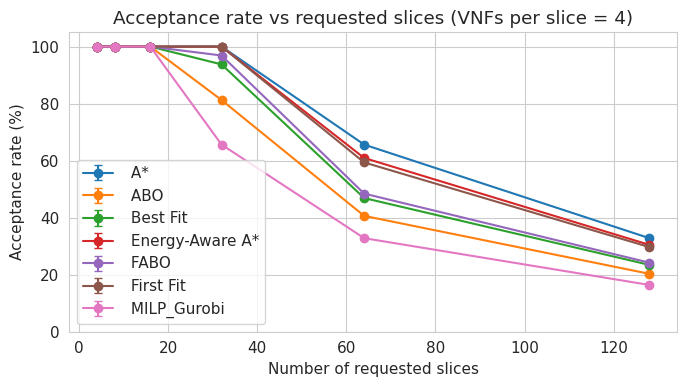

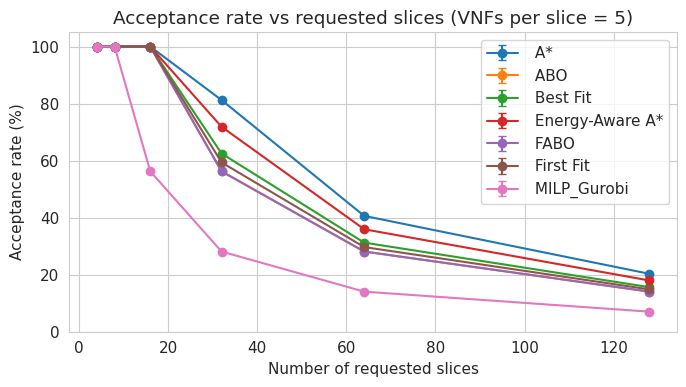

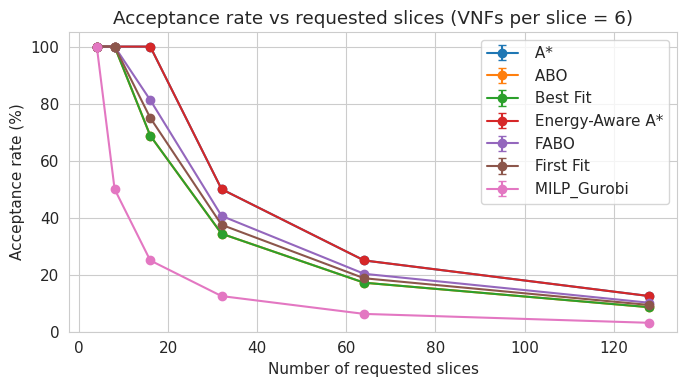

In [20]:
# Aggregate across seeds: mean + std
g = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])["acceptance_rate"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

vnf_list = sorted(g["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure()
    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(x, y, yerr=yerr, marker="o", linewidth=1.5, capsize=3, label=method)

    plt.xlabel("Number of requested slices")
    plt.ylabel("Acceptance rate (%)")
    plt.title(f"Acceptance rate vs requested slices (VNFs per slice = {v})")
    plt.ylim(0, 105)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Map common alternatives to expected names (if needed)
rename_map = {}
if "method" not in df.columns:
    for alt in ["methods", "algorithm", "algo", "approach", "solver"]:
        if alt in df.columns:
            rename_map[alt] = "method"
            break
if "num_slices" not in df.columns:
    for alt in ["slices", "n_slices", "requested_slices", "requested"]:
        if alt in df.columns:
            rename_map[alt] = "num_slices"
            break
if "num_vnfs_per_slice" not in df.columns:
    for alt in ["vnfs_per_slice", "vnf_per_slice", "num_vnfs", "chain_len", "k"]:
        if alt in df.columns:
            rename_map[alt] = "num_vnfs_per_slice"
            break
if "accepted" not in df.columns:
    for alt in ["accepted_slices", "n_accepted", "accepted_count"]:
        if alt in df.columns:
            rename_map[alt] = "accepted"
            break
if "total_energy" not in df.columns:
    for alt in ["energy", "total_power", "power", "energy_total"]:
        if alt in df.columns:
            rename_map[alt] = "total_energy"
            break

df = df.rename(columns=rename_map)

# Validate required columns
required_cols = {
    "method", "num_slices", "num_vnfs_per_slice",
    "seed", "accepted", "total_energy"
}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Available: {list(df.columns)}")

# Ensure numeric types
for col in ["num_slices", "num_vnfs_per_slice", "seed", "accepted", "total_energy"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=list(required_cols))

# Exclude methods
EXCLUDED_METHODS = {"First Fit", "Best Fit"}
df = df[~df["method"].isin(EXCLUDED_METHODS)].copy()

# Keep only cases with at least one accepted slice
df = df[df["accepted"] > 0].copy()

# Energy per accepted slice (safe)
df["energy_per_accepted_slice"] = df["total_energy"] / df["accepted"]

df.head()


,timestamp,num_slices,num_vnfs_per_slice,total_vnfs,seed,method,accepted,total_energy,total_bandwidth,total_latency,runtime_sec,energy_per_accepted_slice
0,2026-01-21 12:20:57,4,2,8,1,A*,4,7.432500,60.0,4.0,0.035530,1.858125
1,2026-01-21 12:20:57,4,2,8,1,ABO,4,3.372500,60.0,8.0,3.557018,0.843125
2,2026-01-21 12:20:57,4,2,8,1,FABO,4,9.449375,60.0,8.0,3.527569,2.362344
3,2026-01-21 12:20:57,4,2,8,1,Best Fit,4,3.432500,60.0,4.0,0.014261,0.858125
4,2026-01-21 12:20:57,4,2,8,1,First Fit,4,3.372500,60.0,12.0,0.002143,0.843125


In [23]:
g = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])
      ["energy_per_accepted_slice"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

# Optional: fixed method order
method_order = [
    "MILP_Gurobi",
    "A*",
    "Energy-Aware A*",
    "ABO",
    "FABO"
]

present_methods = [m for m in method_order if m in g["method"].unique()]
if not present_methods:
    present_methods = sorted(g["method"].unique())

g.head()


,num_vnfs_per_slice,num_slices,method,mean,std,count
0,2,4,A*,1.858125,NaN,1
1,2,4,ABO,0.843125,NaN,1
2,2,4,Best Fit,0.858125,NaN,1
3,2,4,Energy-Aware A*,1.858125,NaN,1
4,2,4,FABO,2.362344,NaN,1


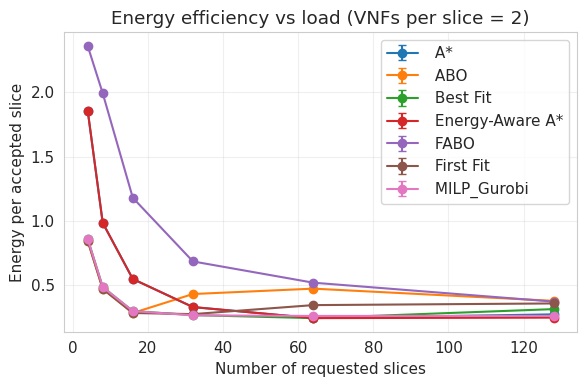

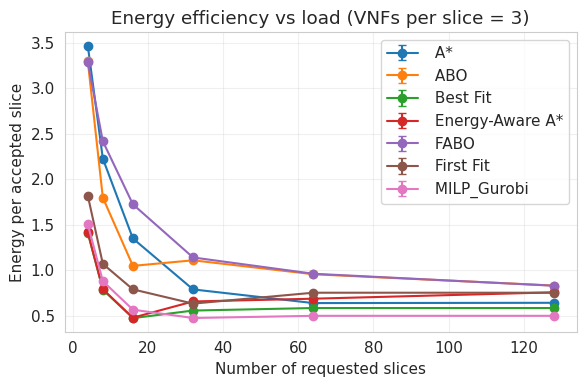

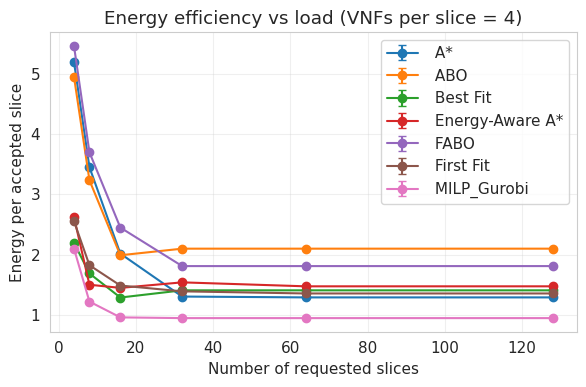

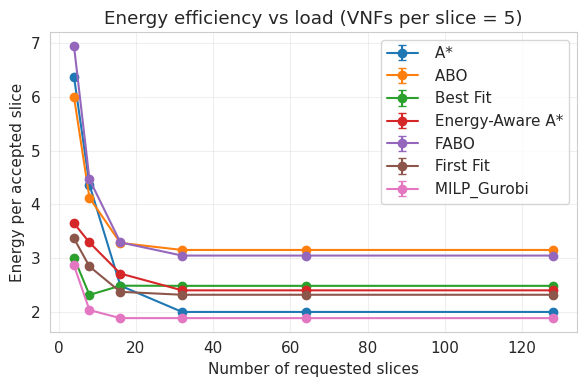

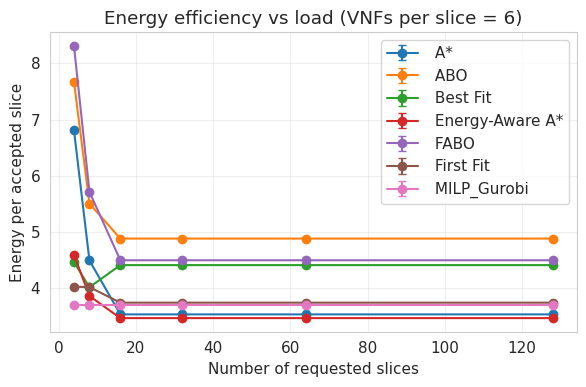

In [24]:
vnf_list = sorted(g["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure(figsize=(6, 4))

    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(
            x, y,
            yerr=yerr,
            marker="o",
            linewidth=1.5,
            capsize=3,
            label=method,
        )

    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy per accepted slice")
    plt.title(f"Energy efficiency vs load (VNFs per slice = {v})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [26]:
import pandas as pd

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Map common alternatives if needed
rename_map = {}
if "method" not in df.columns:
    for alt in ["methods", "algorithm", "algo", "approach", "solver"]:
        if alt in df.columns:
            rename_map[alt] = "method"
            break
if "num_slices" not in df.columns:
    for alt in ["slices", "n_slices", "requested_slices", "requested"]:
        if alt in df.columns:
            rename_map[alt] = "num_slices"
            break
if "accepted" not in df.columns:
    for alt in ["accepted_slices", "n_accepted", "accepted_count"]:
        if alt in df.columns:
            rename_map[alt] = "accepted"
            break

df = df.rename(columns=rename_map)

# Validate required columns
required_cols = {"method", "num_slices", "accepted"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Available: {list(df.columns)}")

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")

df = df.dropna(subset=["method", "num_slices", "accepted"])

# Remove First Fit e Best Fit (como já decidido)
df = df[~df["method"].isin(["First Fit", "Best Fit"])].copy()

# 100% de aceitação → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 130


In [12]:
energy_agg = (
    df_100
    .groupby(["method", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg


,method,num_slices,mean_energy,std_energy
0,A*,4,22.239750,10.734535
1,A*,8,31.238625,17.012150
2,A*,16,26.705000,14.770103
3,A*,32,26.525000,12.243285
4,ABO,4,21.141250,12.455145
5,ABO,8,23.611875,15.609606
6,ABO,16,27.402708,19.757128
7,ABO,32,34.300937,15.948091
8,ABO,64,37.521875,0.000000
9,Energy-Aware A*,4,17.612250,11.255962


Cenários com 100% de aceitação: 130


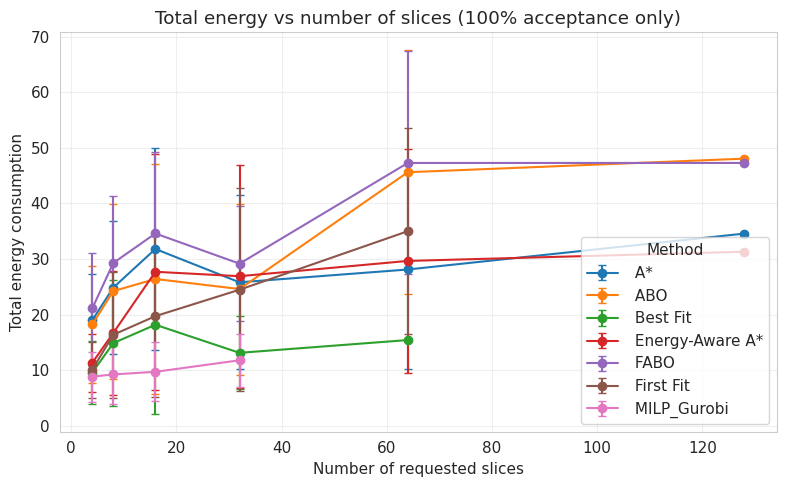

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load ---
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
df.columns = [c.strip().lower() for c in df.columns]

# --- Basic validation + numeric casting ---
required_cols = {"method", "num_slices", "accepted", "total_energy"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in scalability_results.csv: {missing}. Available: {list(df.columns)}")

df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")
df = df.dropna(subset=["method", "num_slices", "accepted", "total_energy"])

# --- Exclude methods ---
EXCLUDED_METHODS = {"First Fit", "Best Fit"}
df = df[~df["method"].isin(EXCLUDED_METHODS)].copy()

# --- 100% acceptance only ---
df_100 = df[df["accepted"] == df["num_slices"]].copy()
print("Cenários com 100% de aceitação:", len(df_100))

# --- Aggregate mean/std energy per method & num_slices ---
energy_agg = (
    df_100.groupby(["method", "num_slices"], as_index=False)
          .agg(
              mean_energy=("total_energy", "mean"),
              std_energy=("total_energy", "std"),
              n=("total_energy", "count"),
          )
)

# --- Plot ---
plt.figure(figsize=(8, 5))

for method in energy_agg["method"].unique():
    sub = energy_agg[energy_agg["method"] == method].sort_values("num_slices").copy()
    yerr = sub["std_energy"].fillna(0.0)

    plt.errorbar(
        sub["num_slices"],
        sub["mean_energy"],
        yerr=yerr,
        marker="o",
        capsize=3,
        label=method,
    )

plt.xlabel("Number of requested slices")
plt.ylabel("Total energy consumption")
plt.title("Total energy vs number of slices (100% acceptance only)")
plt.legend(title="Method")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Defensive: normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Remove First Fit e Best Fit (como decidido)
df = df[~df["method"].isin(["first fit", "best fit"])].copy()

# Ensure numeric comparison
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")

# 100% acceptance → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 130


In [34]:
energy_agg = (
    df_100
    .groupby(["method", "num_vnfs_per_slice", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg.head()


,method,num_vnfs_per_slice,num_slices,mean_energy,std_energy
0,A*,2,4,7.4325,NaN
1,A*,2,8,7.8650,NaN
2,A*,2,16,8.7300,NaN
3,A*,2,32,10.4600,NaN
4,A*,2,64,15.4100,NaN


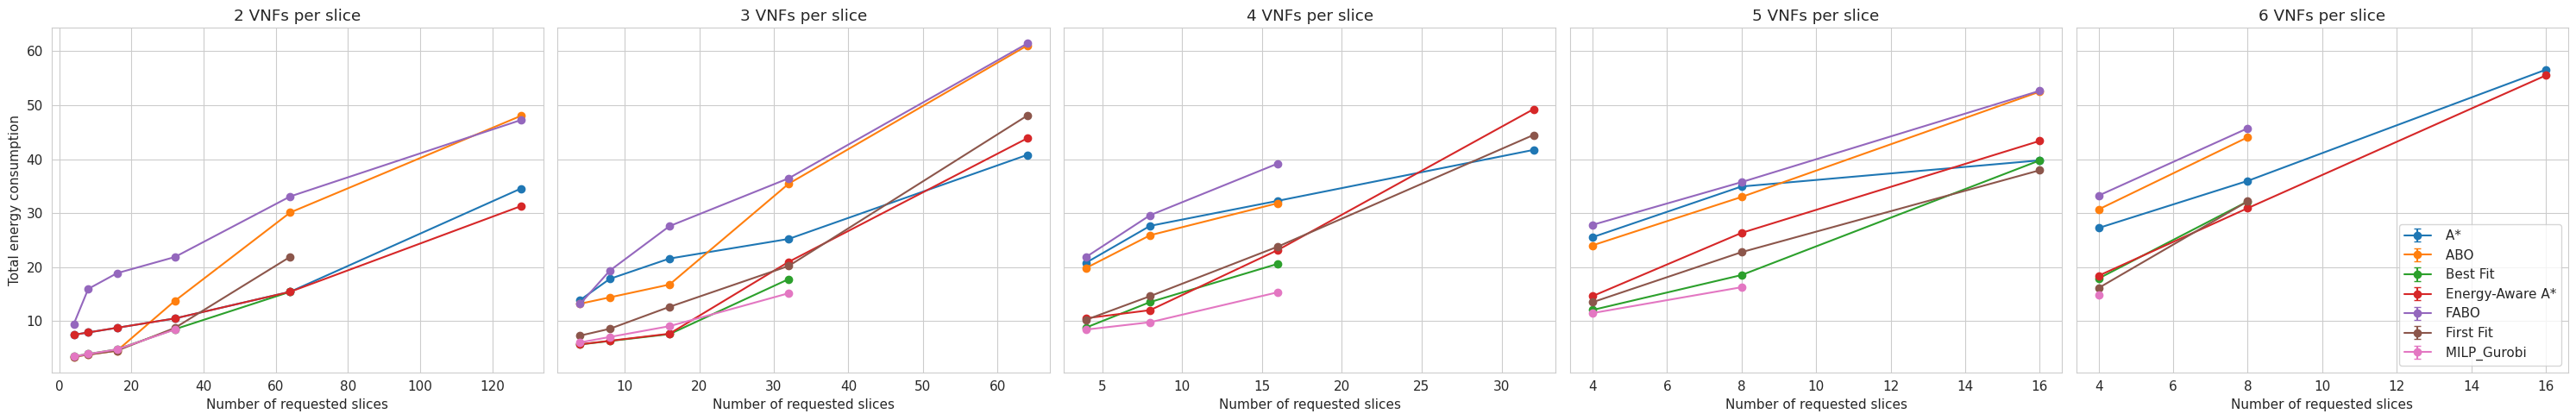

In [35]:
import matplotlib.pyplot as plt

vnf_values = sorted(energy_agg["num_vnfs_per_slice"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(vnf_values),
    figsize=(6 * len(vnf_values), 5),
    sharey=True,
)

if len(vnf_values) == 1:
    axes = [axes]

for ax, vnf in zip(axes, vnf_values):
    sub_vnf = energy_agg[energy_agg["num_vnfs_per_slice"] == vnf]

    for method in sub_vnf["method"].unique():
        sub = sub_vnf[sub_vnf["method"] == method]

        ax.errorbar(
            sub["num_slices"],
            sub["mean_energy"],
            yerr=sub["std_energy"],
            marker="o",
            capsize=3,
            label=method,
        )

    ax.set_title(f"{vnf} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend()
plt.tight_layout()
plt.show()


Cenários com 100% de aceitação: 130


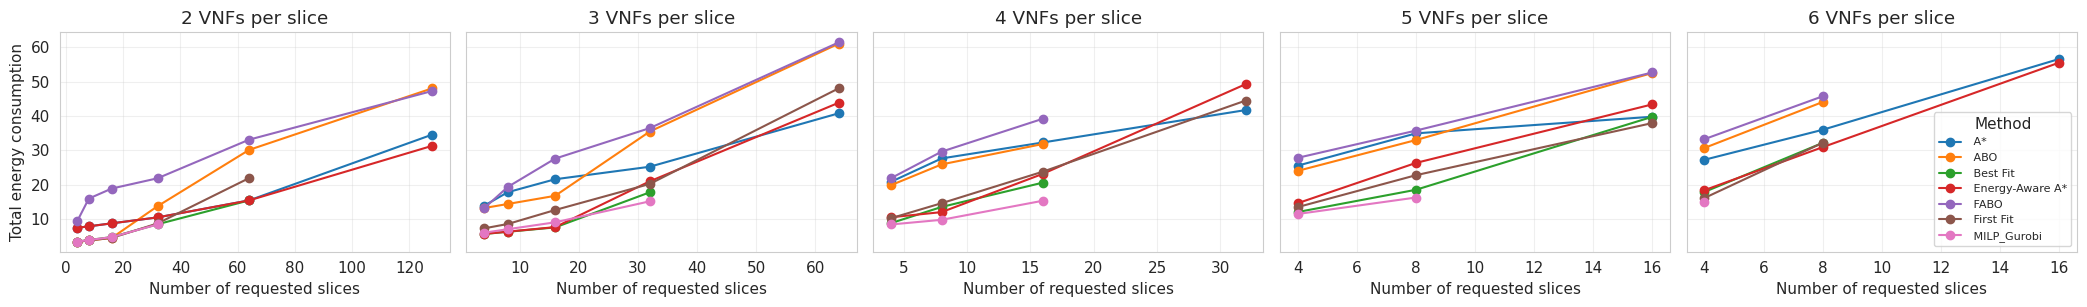

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load results ---
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
df.columns = [c.strip().lower() for c in df.columns]

# --- Remove methods you don't want ---
methods_to_exclude = ["first fit", "best fit"]
if "method" not in df.columns:
    raise ValueError(f"Column 'method' not found. Available: {list(df.columns)}")

df = df[~df["method"].isin(methods_to_exclude)].copy()

# --- Ensure numeric types ---
for col in ["num_slices", "num_vnfs_per_slice", "total_energy", "accepted"]:
    if col not in df.columns:
        raise ValueError(f"Missing column '{col}'. Available: {list(df.columns)}")
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- Drop invalid rows ---
df = df.dropna(subset=["num_slices", "num_vnfs_per_slice", "total_energy", "method", "accepted"])

# --- Keep only 100% acceptance scenarios (fair energy comparison) ---
df_100 = df[df["accepted"] == df["num_slices"]].copy()
print("Cenários com 100% de aceitação:", len(df_100))

# --- Aggregate across seeds (mean). Change to 'median' if you prefer robustness. ---
agg = (
    df_100.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
          .agg(total_energy=("total_energy", "mean"))
)

# --- Sort for clean lines ---
agg = agg.sort_values(["num_vnfs_per_slice", "method", "num_slices"])

# --- Subplots layout (1 row like your example) ---
vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.2 * k, 3.2), sharey=True)
if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v]

    for method, g in sub.groupby("method"):
        g = g.sort_values("num_slices")
        ax.plot(
            g["num_slices"],
            g["total_energy"],
            marker="o",
            label=method,
        )

    ax.set_title(f"{int(v)} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Total energy consumption")

# Legend once
axes[-1].legend(loc="best", fontsize=8, title="Method")

plt.tight_layout()
plt.show()


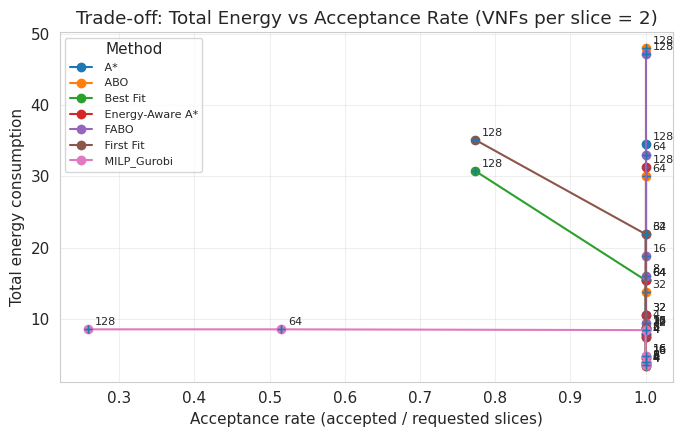

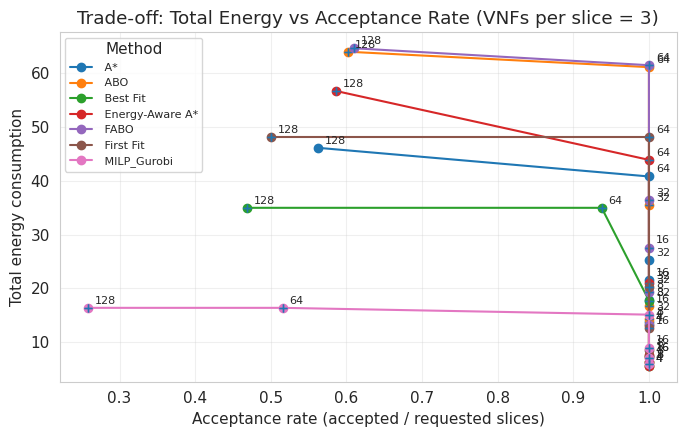

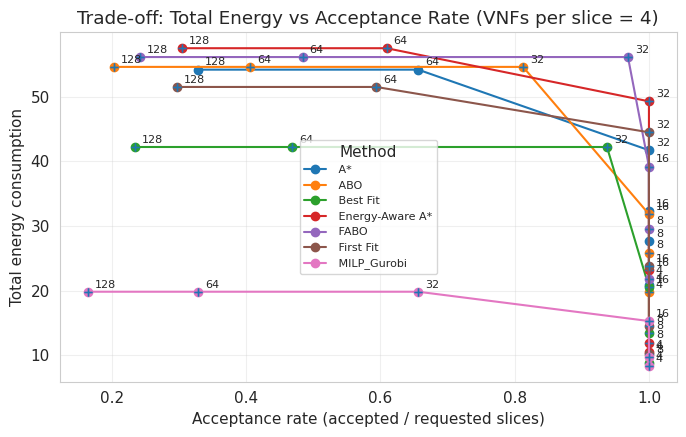

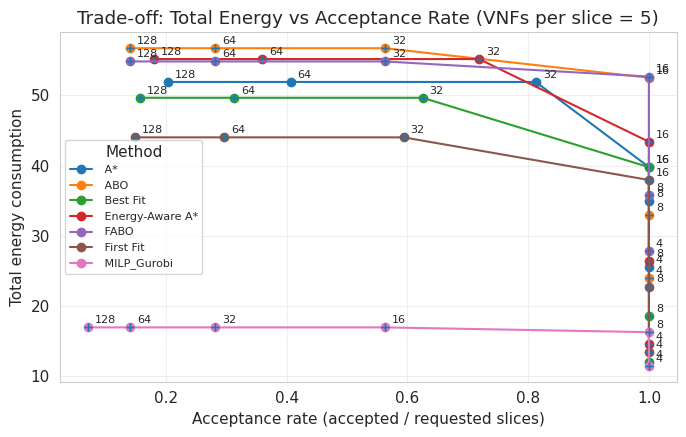

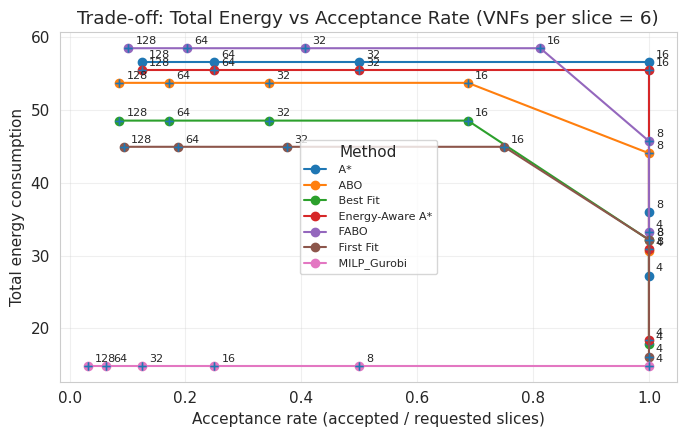

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")
df.columns = [c.strip().lower() for c in df.columns]

# --- Validate required columns ---
required = {"method", "num_slices", "num_vnfs_per_slice", "seed", "accepted", "total_energy"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Available: {list(df.columns)}")

# --- Exclude methods ---
methods_to_exclude = {"first fit", "best fit"}
df = df[~df["method"].isin(methods_to_exclude)].copy()

# --- Ensure numeric ---
for col in ["num_slices", "num_vnfs_per_slice", "seed", "accepted", "total_energy"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["method", "num_slices", "num_vnfs_per_slice", "seed", "accepted", "total_energy"])

# --- Acceptance rate ---
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# --- Aggregate per scenario (method, num_slices, seed) to avoid duplicated points ---
scenario = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices", "seed"], as_index=False)
      .agg(
          acceptance_rate=("acceptance_rate", "mean"),
          total_energy=("total_energy", "mean"),
      )
)

# --- Then aggregate across seeds: mean + std for error bars ---
trade = (
    scenario.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
            .agg(
                mean_accept=("acceptance_rate", "mean"),
                std_accept=("acceptance_rate", "std"),
                mean_energy=("total_energy", "mean"),
                std_energy=("total_energy", "std"),
                n=("total_energy", "count"),
            )
)

trade = trade.sort_values(["num_vnfs_per_slice", "method", "num_slices"])

# --- Plot: one figure per VNF-per-slice configuration ---
for num_vnfs, df_vnf in trade.groupby("num_vnfs_per_slice"):
    plt.figure(figsize=(7, 4.5))

    for method, g in df_vnf.groupby("method"):
        g = g.sort_values("num_slices")

        # Points (trade-off curve)
        plt.plot(
            g["mean_accept"],
            g["mean_energy"],
            marker="o",
            label=method,
        )

        # Optional: error bars (std across seeds)
        xerr = g["std_accept"].fillna(0.0)
        yerr = g["std_energy"].fillna(0.0)
        plt.errorbar(
            g["mean_accept"],
            g["mean_energy"],
            xerr=xerr,
            yerr=yerr,
            fmt="none",
            capsize=3,
        )

        # Optional: annotate each point with num_slices (helps interpretation)
        for _, row in g.iterrows():
            plt.annotate(
                str(int(row["num_slices"])),
                (row["mean_accept"], row["mean_energy"]),
                textcoords="offset points",
                xytext=(5, 3),
                fontsize=8,
            )

    plt.xlabel("Acceptance rate (accepted / requested slices)")
    plt.ylabel("Total energy consumption")
    plt.title(f"Trade-off: Total Energy vs Acceptance Rate (VNFs per slice = {int(num_vnfs)})")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Method", fontsize=8)
    plt.tight_layout()
    plt.show()


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def pareto_frontier(df_xy, x_col, y_col):
    # English: Returns a boolean mask of non-dominated points (maximize x, minimize y).
    x = df_xy[x_col].to_numpy()
    y = df_xy[y_col].to_numpy()
    n = len(df_xy)
    keep = np.ones(n, dtype=bool)

    for i in range(n):
        if not keep[i]:
            continue
        # English: j dominates i if x_j >= x_i and y_j <= y_i, with at least one strict.
        dominates = (x >= x[i]) & (y <= y[i]) & ((x > x[i]) | (y < y[i]))
        if np.any(dominates):
            keep[i] = False
    return keep

# Load results
df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Optional: remove methods you don't want
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")

# Acceptance rate = accepted / requested
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# Drop invalid rows
df = df.dropna(subset=["acceptance_rate", "total_energy", "num_vnfs_per_slice", "method"])

# Aggregate across seeds (mean) per (vnfs, method, num_slices)
agg = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
      .agg(
          acceptance_rate=("acceptance_rate", "mean"),
          total_energy=("total_energy", "mean"),
      )
)

vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.8 * k, 3.6), sharey=True)

if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v].copy()

    # Scatter per method
    for method, g in sub.groupby("method"):
        ax.scatter(g["acceptance_rate"], g["total_energy"], label=method, alpha=0.85)

    # Global Pareto frontier (across all methods)
    mask = pareto_frontier(sub[["acceptance_rate", "total_energy"]],
                           x_col="acceptance_rate", y_col="total_energy")
    pf = sub.loc[mask].sort_values(["acceptance_rate", "total_energy"])

    # Draw frontier line
    ax.plot(pf["acceptance_rate"], pf["total_energy"], linestyle="--", marker="o")

    ax.set_title(f"VNFs per slice = {int(v)}")
    ax.set_xlabel("Acceptance rate (accepted / requested)")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


KeyError: 'method'

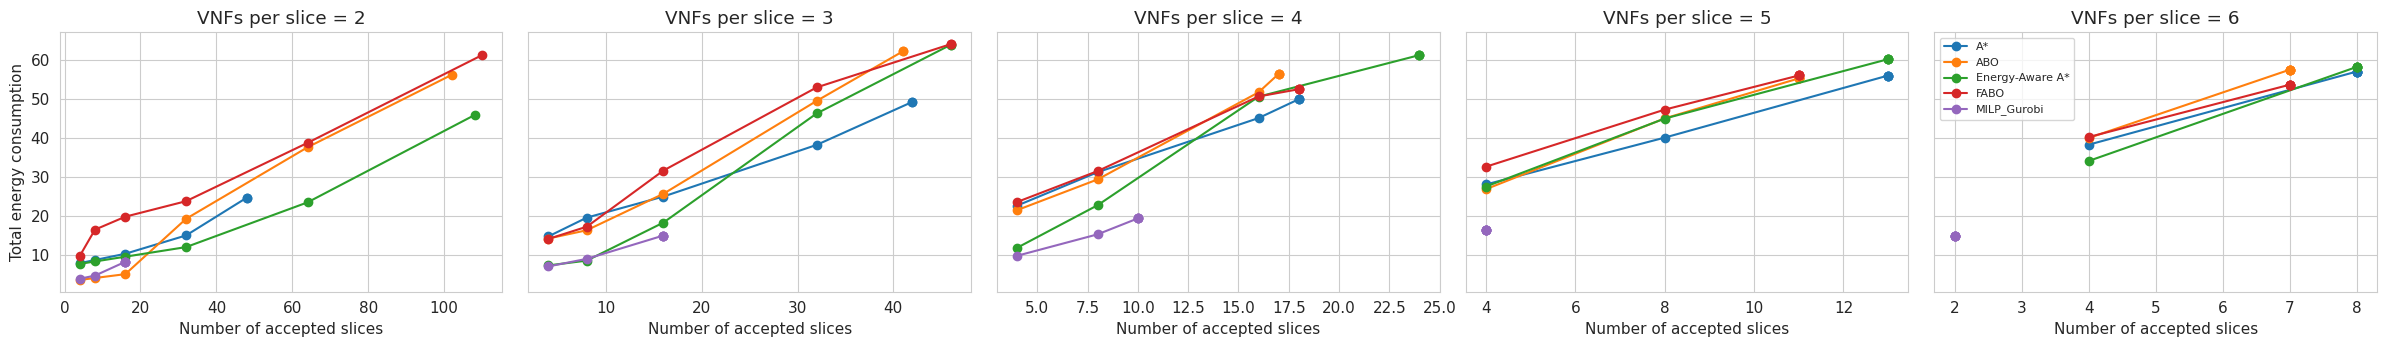

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Optional: remove methods you don't want
methods_to_exclude = ["First Fit", "Best Fit"]
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric types
df["num_slices"] = pd.to_numeric(df["num_slices"], errors="coerce")
df["num_vnfs_per_slice"] = pd.to_numeric(df["num_vnfs_per_slice"], errors="coerce")
df["accepted"] = pd.to_numeric(df["accepted"], errors="coerce")
df["total_energy"] = pd.to_numeric(df["total_energy"], errors="coerce")

df = df.dropna(subset=["num_vnfs_per_slice", "method", "accepted", "total_energy"])

# Aggregate across seeds (mean) per (vnfs, method, num_slices)
agg = (
    df.groupby(["num_vnfs_per_slice", "method", "num_slices"], as_index=False)
      .agg(
          accepted=("accepted", "mean"),
          total_energy=("total_energy", "mean"),
      )
)

# Sort and build subplots like your example
vnf_values = sorted(agg["num_vnfs_per_slice"].unique())
k = len(vnf_values)

fig, axes = plt.subplots(1, k, figsize=(4.8 * k, 3.6), sharey=True)

if k == 1:
    axes = [axes]

for ax, v in zip(axes, vnf_values):
    sub = agg[agg["num_vnfs_per_slice"] == v].copy()

    for method, g in sub.groupby("method"):
        g = g.sort_values("accepted")
        ax.plot(
            g["accepted"],
            g["total_energy"],
            marker="o",
            label=method,
        )

    ax.set_title(f"VNFs per slice = {int(v)}")
    ax.set_xlabel("Number of accepted slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")
axes[-1].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [22]:
RESULTS_DIR = "./results/2026-01-19_09-04-19/"

df = pd.read_csv(f"{RESULTS_DIR}/scalability_results.csv")

# Remove First Fit e Best Fit (como já decidido)
df = df[~df["method"].isin(["First Fit", "Best Fit"])].copy()

# 100% de aceitação → accepted == num_slices
df_100 = df[df["accepted"] == df["num_slices"]].copy()

print("Cenários com 100% de aceitação:", len(df_100))


Cenários com 100% de aceitação: 395


In [23]:
energy_agg = (
    df_100
    .groupby(["method", "num_vnfs_per_slice", "num_slices"])
    .agg(
        mean_energy=("total_energy", "mean"),
        std_energy=("total_energy", "std"),
    )
    .reset_index()
)

energy_agg


,method,num_vnfs_per_slice,num_slices,mean_energy,std_energy
0,A*,2,4,7.417500,0.0
1,A*,2,8,7.820000,0.0
2,A*,2,16,8.655000,0.0
3,A*,2,32,10.295000,0.0
4,A*,2,64,15.890000,0.0
...,...,...,...,...,...
74,FABO,5,4,26.759375,0.0
75,FABO,5,8,36.753125,0.0
76,FABO,5,16,55.523125,0.0
77,FABO,6,4,34.467500,0.0


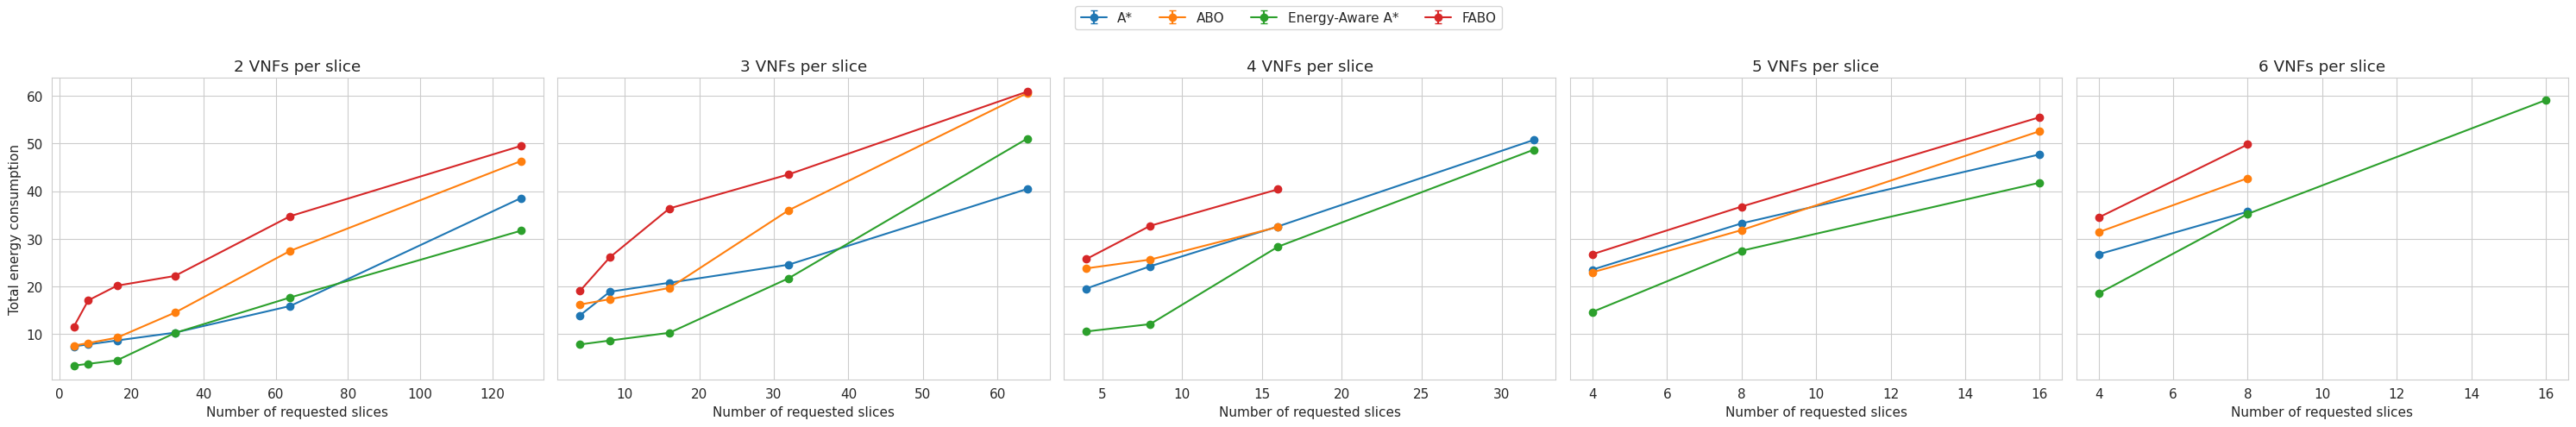

In [24]:
import matplotlib.pyplot as plt

vnf_values = sorted(energy_agg["num_vnfs_per_slice"].unique())

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(vnf_values),
    figsize=(6 * len(vnf_values), 5),
    sharey=True,
)

# Ensure axes is iterable
if len(vnf_values) == 1:
    axes = [axes]

for ax, vnf in zip(axes, vnf_values):
    sub_vnf = energy_agg[energy_agg["num_vnfs_per_slice"] == vnf]

    for method in sub_vnf["method"].unique():
        sub = sub_vnf[sub_vnf["method"] == method]

        ax.errorbar(
            sub["num_slices"],
            sub["mean_energy"],
            yerr=sub["std_energy"],
            marker="o",
            capsize=3,
            label=method,  # Label must be set for legend
        )

    ax.set_title(f"{vnf} VNFs per slice")
    ax.set_xlabel("Number of requested slices")
    ax.grid(True)

axes[0].set_ylabel("Total energy consumption")

# --- GLOBAL legend (fixes missing MILP) ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=len(labels),
)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space for legend
plt.show()


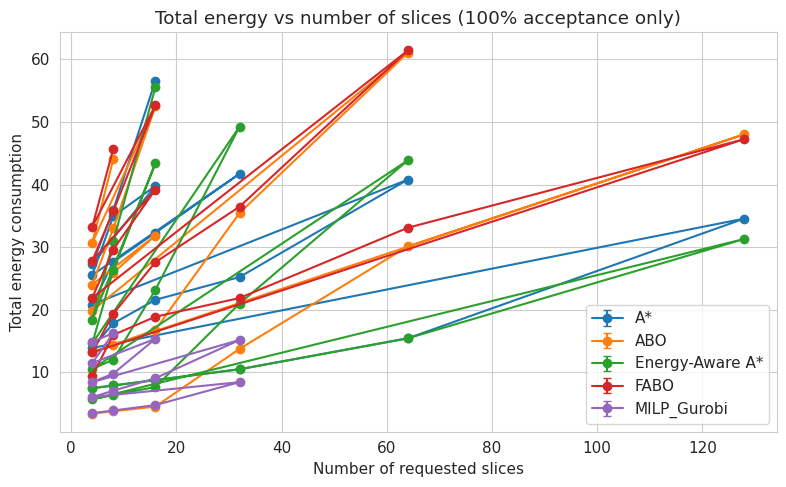

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for method in energy_agg["method"].unique():
    sub = energy_agg[energy_agg["method"] == method]

    plt.errorbar(
        sub["num_slices"],
        sub["mean_energy"],
        yerr=sub["std_energy"],
        marker="o",
        capsize=3,
        label=method,
    )

plt.xlabel("Number of requested slices")
plt.ylabel("Total energy consumption")
plt.title("Total energy vs number of slices (100% acceptance only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2994491/127663976.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


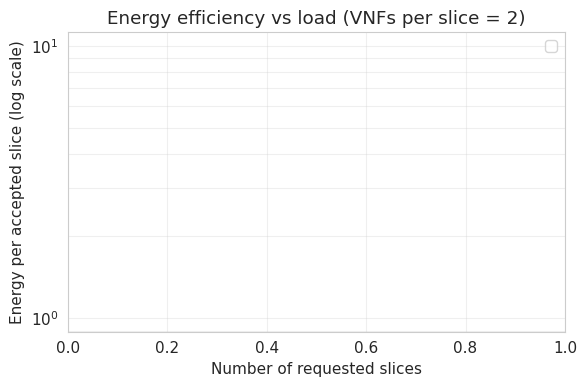

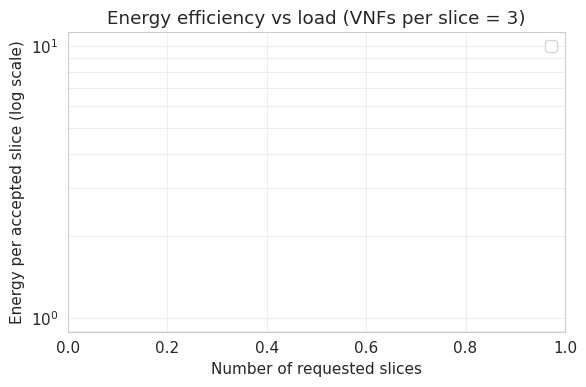

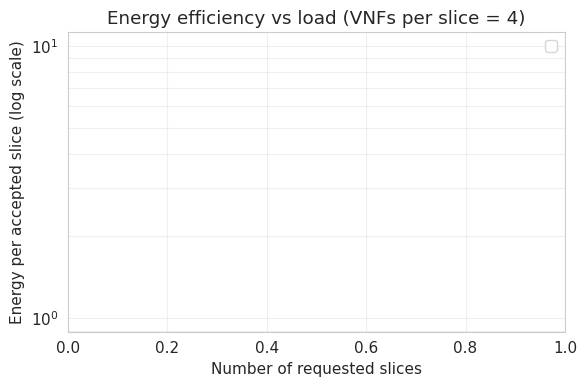

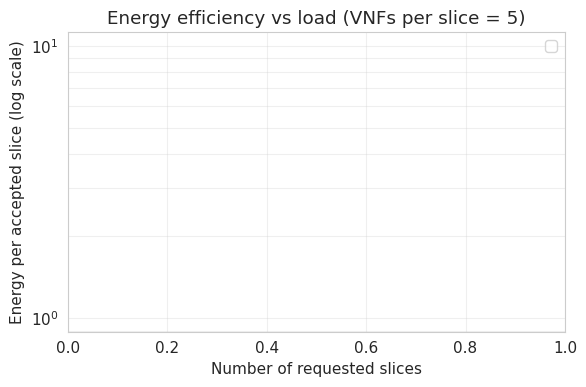

KeyError: 'mean'

<Figure size 600x400 with 0 Axes>

In [27]:
for v in vnf_list:
    sub = g[g["num_vnfs_per_slice"] == v].copy()

    plt.figure(figsize=(6, 4))

    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        plt.plot(
            msub["num_slices"],
            msub["mean"],
            marker="o",
            linewidth=1.5,
            label=method,
        )

    plt.yscale("log")
    plt.xlabel("Number of requested slices")
    plt.ylabel("Energy per accepted slice (log scale)")
    plt.title(f"Energy efficiency vs load (VNFs per slice = {v})")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [28]:
for method in present_methods:
    sub = df[df["method"] == method].copy()
    if sub.empty:
        continue

    pivot = (
        sub.groupby(["num_vnfs_per_slice", "num_slices"])["acceptance_rate"]
           .mean()
           .reset_index()
           .pivot(index="num_vnfs_per_slice", columns="num_slices", values="acceptance_rate")
           .sort_index()
    )

    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label="Acceptance rate (%)")
    plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
    plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
    plt.xlabel("Number of requested slices")
    plt.ylabel("VNFs per slice")
    plt.title(f"Acceptance rate heatmap — {method}")
    plt.tight_layout()
    plt.show()


KeyError: 'Column not found: acceptance_rate'

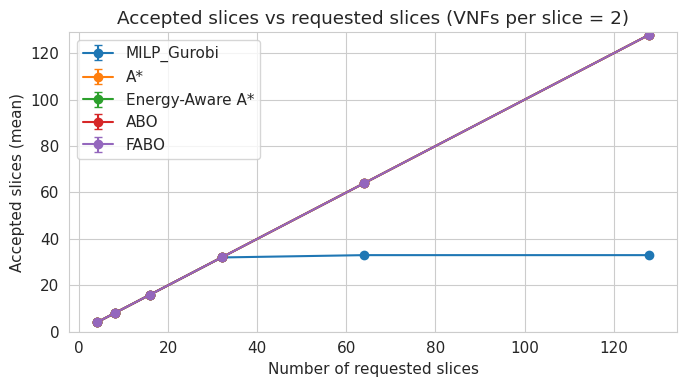

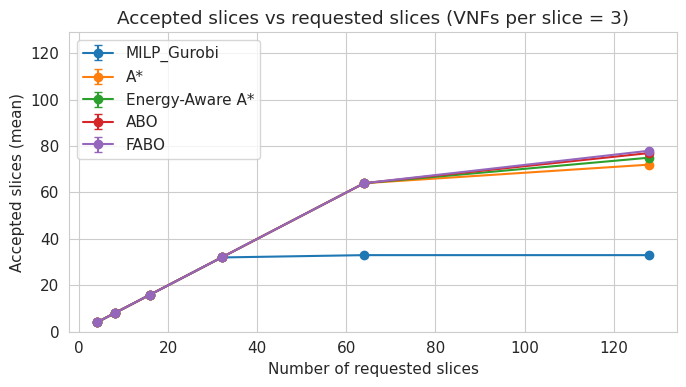

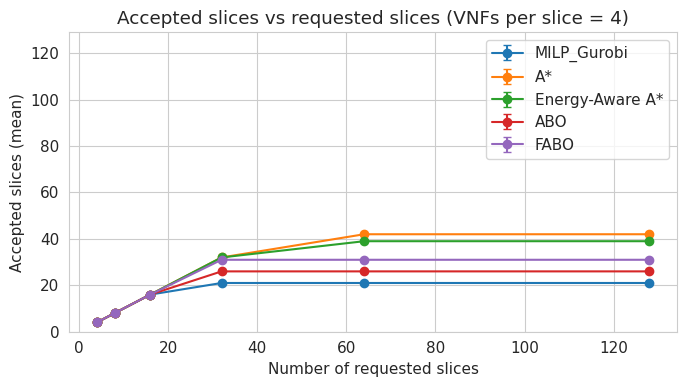

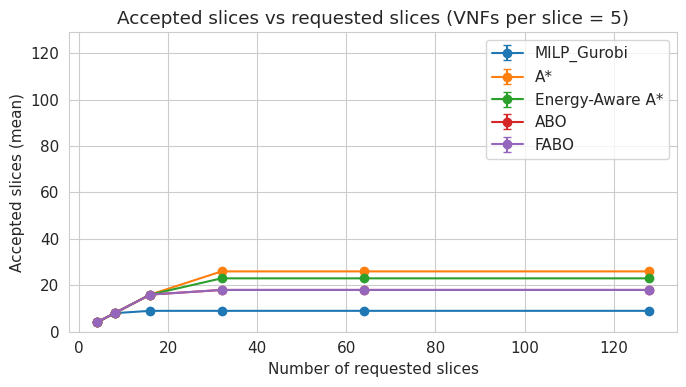

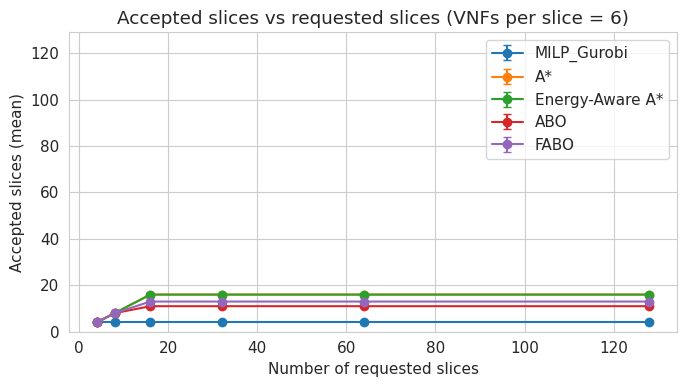

In [29]:
g2 = (
    df.groupby(["num_vnfs_per_slice", "num_slices", "method"])["accepted"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

vnf_list = sorted(g2["num_vnfs_per_slice"].unique())

for v in vnf_list:
    sub = g2[g2["num_vnfs_per_slice"] == v].copy()

    plt.figure()
    for method in present_methods:
        msub = sub[sub["method"] == method].sort_values("num_slices")
        if msub.empty:
            continue

        x = msub["num_slices"].to_numpy()
        y = msub["mean"].to_numpy()
        yerr = msub["std"].fillna(0).to_numpy()

        plt.errorbar(x, y, yerr=yerr, marker="o", linewidth=1.5, capsize=3, label=method)

    plt.xlabel("Number of requested slices")
    plt.ylabel("Accepted slices (mean)")
    plt.title(f"Accepted slices vs requested slices (VNFs per slice = {v})")
    plt.ylim(0, max(sub["num_slices"]) + 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


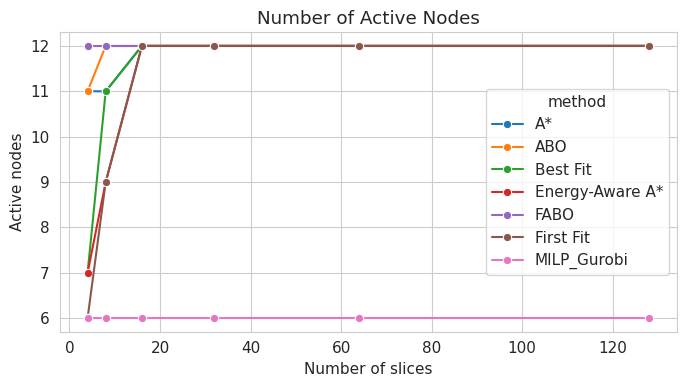

In [30]:
active_nodes = (
    df_node_cpu[df_node_cpu["cpu_used"] > 0]
    .groupby(["method", "num_slices"])["node"]
    .nunique()
    .reset_index(name="active_nodes")
)

sns.lineplot(
    data=active_nodes,
    x="num_slices",
    y="active_nodes",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Active nodes")
plt.title("Number of Active Nodes")
plt.tight_layout()
plt.show()


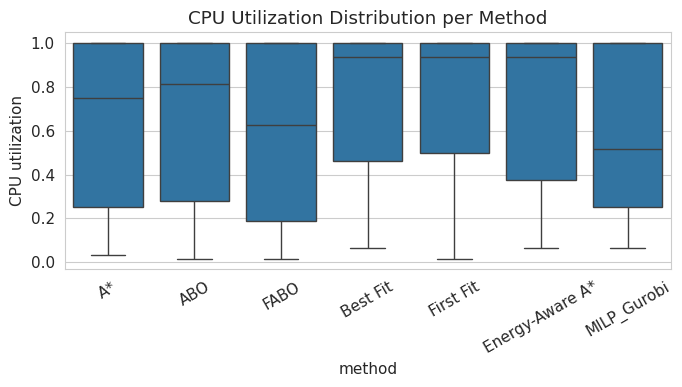

In [31]:
df_cpu_nonzero = df_node_cpu[df_node_cpu["cpu_used"] > 0]

sns.boxplot(
    data=df_cpu_nonzero,
    x="method",
    y="cpu_utilization"
)

plt.ylabel("CPU utilization")
plt.title("CPU Utilization Distribution per Method")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


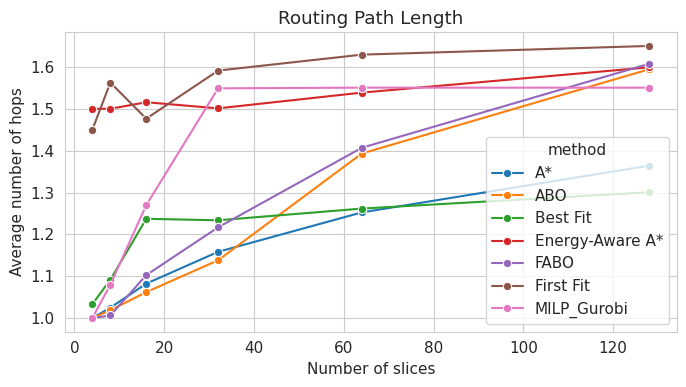

In [32]:
route_len = (
    df_routes
    .groupby(["method", "num_slices"])["num_hops"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=route_len,
    x="num_slices",
    y="num_hops",
    hue="method",
    marker="o"
)

plt.xlabel("Number of slices")
plt.ylabel("Average number of hops")
plt.title("Routing Path Length")
plt.tight_layout()
plt.show()


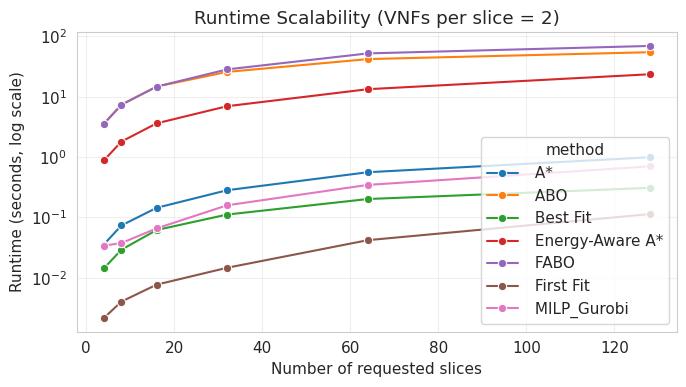

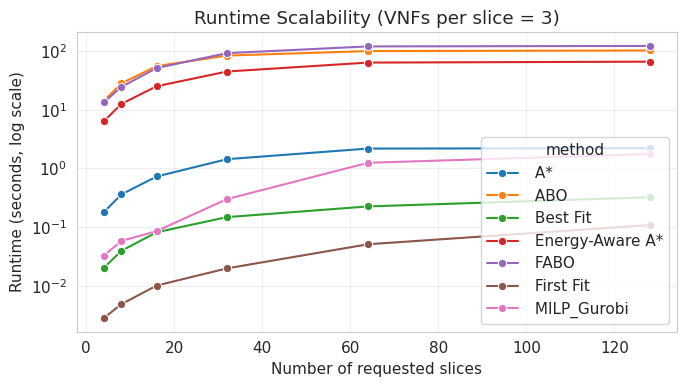

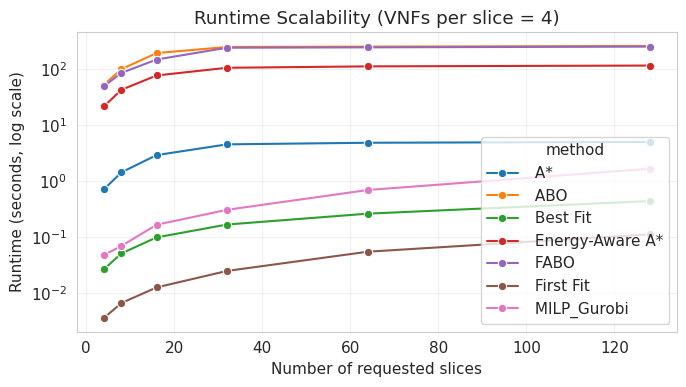

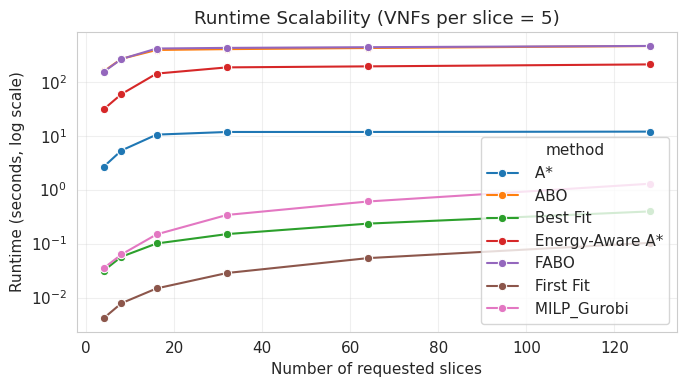

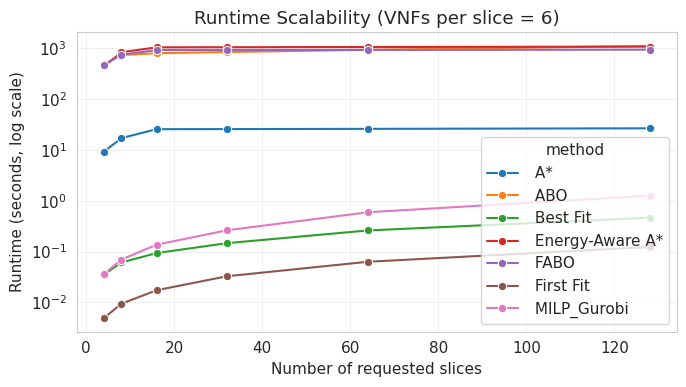

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Defensive copy
df = df_metrics.copy()
df.columns = [c.strip().lower() for c in df.columns]

# Remove methods not considered
methods_to_exclude = {"First Fit", "Best Fit"}
df = df[~df["method"].isin(methods_to_exclude)].copy()

# Ensure numeric
for col in ["num_slices", "num_vnfs_per_slice", "runtime_sec", "seed"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop invalid rows
df = df.dropna(subset=["method", "num_slices", "num_vnfs_per_slice", "runtime_sec", "seed"])

# --- Aggregate runtime per scenario (method, slices, seed) ---
scenario_runtime = (
    df.groupby(
        ["num_vnfs_per_slice", "method", "num_slices", "seed"],
        as_index=False
    )
    .agg(runtime_sec=("runtime_sec", "mean"))
)

# --- Aggregate across seeds (mean runtime) ---
runtime_agg = (
    scenario_runtime.groupby(
        ["num_vnfs_per_slice", "method", "num_slices"],
        as_index=False
    )
    .agg(mean_runtime=("runtime_sec", "mean"))
)

runtime_agg = runtime_agg.sort_values(
    ["num_vnfs_per_slice", "method", "num_slices"]
)

# --- Plot: one figure per VNF-per-slice scenario ---
for num_vnfs, df_vnf in runtime_agg.groupby("num_vnfs_per_slice"):
    plt.figure(figsize=(7, 4))

    sns.lineplot(
        data=df_vnf,
        x="num_slices",
        y="mean_runtime",
        hue="method",
        marker="o",
    )

    plt.yscale("log")
    plt.xlabel("Number of requested slices")
    plt.ylabel("Runtime (seconds, log scale)")
    plt.title(f"Runtime Scalability (VNFs per slice = {int(num_vnfs)})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
